In [1]:
import numpy as np 
import pandas as pd
import torch 
from bokeh.models import ColumnDataSource

import sys
import os
import pickle 
current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

from constants.paths import FOLDER_PATH

## Get NetMob consumption around station 

In [ ]:
from load_inputs.netmob_POIs_per_station import extract_apps_tags_modes
stations = ['AMP', 'BLA', 'BRO', 'COR', 'CRO', 'CUS', 'FLA', 'GAR', 'GIL', 'GRA', 'HEN', 'JAU', 'LAE', 'MAC', 'MER', 'PAR', 'PRY', 'SAN', 'SOI', 'VEN',
            'BEL', 'BON', 'CHA', 'CPA', 'CUI', 'DEB', 'FOC', 'GER', 'GOR', 'GUI', 'HOT', 'JEA', 'LUM', 'MAS', 'OGA', 'PER', 'REP', 'SAX', 'VAI', 'VMY']
Apps = ['Instagram', 'Deezer','Web_Weather','Web_Downloads','Google_Maps','Twitter','Tor','Microsoft_Office']

for epsilon in [100,300]:
    NetMob_selected_tags = [f'station_epsilon{epsilon}'] # 'station_epislon300'
    globals()[f"data_dict_eps{epsilon}"] = {station_i:{app_j : {} for app_j in Apps} for station_i in stations}
    for station_i in stations:
        for app_j in Apps:
            path_epsilon_around_station = f'POIs/netmob_POI_Lyon/InputsEpsilon/{station_i}'
            data_path,metadata_path = f'{FOLDER_PATH}/{path_epsilon_around_station}/data.npy', f'{FOLDER_PATH}/{path_epsilon_around_station}/metadata.pkl'  #contains 68 apps
            data_app = np.load(open(data_path,"rb"))
            metadata = pickle.load(open(metadata_path,"rb"))

            NetMob_selected_apps = [app_j]
            NetMob_transfer_mode = ['DL']
            data = extract_apps_tags_modes(data_app,metadata,NetMob_selected_apps,NetMob_selected_tags,NetMob_transfer_mode)
            globals()[f"data_dict_eps{epsilon}"][station_i][app_j] = data.reshape(-1)
    if False:
        pickle.dump(data_dict,open('NetMob_samples_epsilon300.pkl','wb'))

# data_dict_eps100
# data_dict_eps300

## Down META du 11 Mai

/tmp/ipykernel_88736/1880594254.py:6: RuntimeWarning: divide by zero encountered in log
  pd.DataFrame(np.log(data_dict_eps300[station_i]['Instagram']),index = coverage_local).plot(title = 'Consumption Instagram in log scale')


<Axes: title={'center': 'Consumption Instagram in log scale'}>

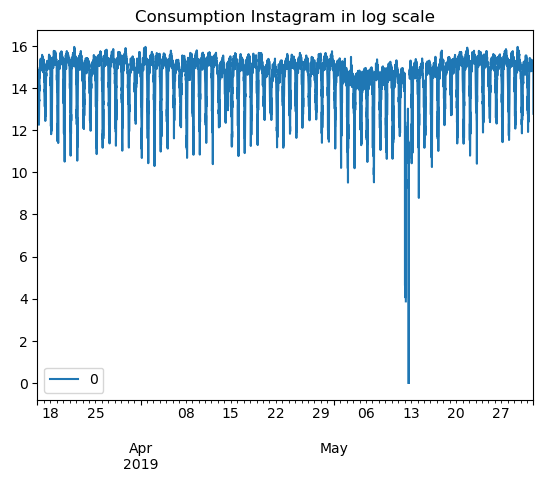

In [3]:
START = '03/16/2019'
END = '06/01/2019'
FREQ = '15min'
coverage_local = pd.date_range(start=START, end=END, freq=FREQ)[:-1]

pd.DataFrame(np.log(data_dict_eps300[station_i]['Instagram']),index = coverage_local).plot(title = 'Consumption Instagram in log scale')

In [34]:
df_to_smooth = pd.DataFrame(np.array(data_dict_eps300_bis).transpose(),index = coverage_local[start:end],columns = ['eps300_smooth'])
data_dict_eps300_bis_smooth = temporal_moving_average(df_to_smooth, window_size=2)

data_dict_eps300_bis_smooth.values.shape

(288, 1)

In [41]:
import numpy as np
import pandas as pd
import bokeh as bk
from datetime import datetime

import os
import sys 
current_path =  os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)
    

DATA_PATH = '../../../../data/rrochas/raw_data'  #'../../../Data' 
SAVE_PATH = '../../../../data/rrochas/preprocessed_data'

def date_transform(date):
    date = ''.join('-'.join('-'.join(date.split('/')).split(':')).split(' '))
    date = datetime.strptime(date, '%d-%m-%Y-%H')
    date = date.strftime('%Y-%m-%d-%H')
    return(date)

def load_weather_data(folder_path = 'Data/Meteo',
                     pathway = 'donnees-meteo.csv',
                     id_stations = [69029001,69299001],
                     columns = ['POSTE','DATE','T','RR1','DRR1','FF','GLO'],
                     dico = {'POSTE':'id_station','DATE':'date','T':'temperature', 
            'RR1':'precip','DRR1':'duree_prec','FF':'wind_ms','GLO':'solar'}
            ):
    # Get 'donnees-meteo' :
    df_weather = pd.read_csv(f"{folder_path}/{pathway}",on_bad_lines='skip', sep = ";")  # Opening data
    df_weather = df_weather[columns]  # Columns selections 
    df_weather = df_weather.rename(columns = dico)  # Rename 
    df_weather = df_weather[df_weather['id_station'].isin(id_stations)]  # Filter station
    
    df_weather['date'] = df_weather['date'].apply(lambda date : date_transform(date) )  # Date transform 
    df_weather['date'] = pd.to_datetime(df_weather['date'])

    return(df_weather)

def fill_empty_values(df_weather):
    grouped_df = df_weather.groupby('date')   # Group station
    for date,group in grouped_df:    
        for index, row in group.iterrows():
            for column in ['temperature','precip','duree_prec','wind_ms','solar']:
                if pd.isnull(row[column]):
                    df_weather.at[index, column] = group[group.index != index][column].values[0]  #Fill empty values 
    return(df_weather)

def sort_and_interpolate(df_weather):
    df_weather = df_weather.set_index(['id_station','date'])    # Sorr by id and by date
    df_weather = df_weather.sort_values(['id_station','date'])

    df_weather = df_weather.interpolate(method = 'linear',limit_direction='forward',axis = 0)   # Interpolate Empty values 
    
    # Convert french format (32,4) to US format (32.4)
    for column in ['temperature','precip','wind_ms']:
        df_weather[column] =  df_weather[column].apply(lambda t : float('.'.join(t.split(','))))
    return(df_weather)

folder_path = f"{DATA_PATH}/Meteo"
csv_path = 'donnees-meteo.csv'
id_stations = [69029001,69299001]  # Lyon Bron and Lyon St-exupery
columns = ['POSTE','DATE','T','RR1','DRR1','FF','GLO']
dico = {'POSTE':'id_station','DATE':'date','T':'temperature', 
        'RR1':'precip','DRR1':'duree_prec','FF':'wind_ms','GLO':'solar'}

df_weather = load_weather_data(folder_path,csv_path,id_stations,columns,dico)
df_weather.head()

/tmp/ipykernel_88736/472035944.py:31: DtypeWarning: Columns (49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather = pd.read_csv(f"{folder_path}/{pathway}",on_bad_lines='skip', sep = ";")  # Opening data


,id_station,date,temperature,precip,duree_prec,wind_ms,solar
35088,69029001,2019-01-01 00:00:00,"6,8",0,0.0,"3,6",0.0
35089,69029001,2019-01-01 01:00:00,"6,7",0,0.0,"3,3",0.0
35090,69029001,2019-01-01 02:00:00,"6,7",0,0.0,"1,5",0.0
35091,69029001,2019-01-01 03:00:00,"6,8",0,0.0,"3,2",0.0
35092,69029001,2019-01-01 04:00:00,"6,7",0,0.0,"3,4",0.0


/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


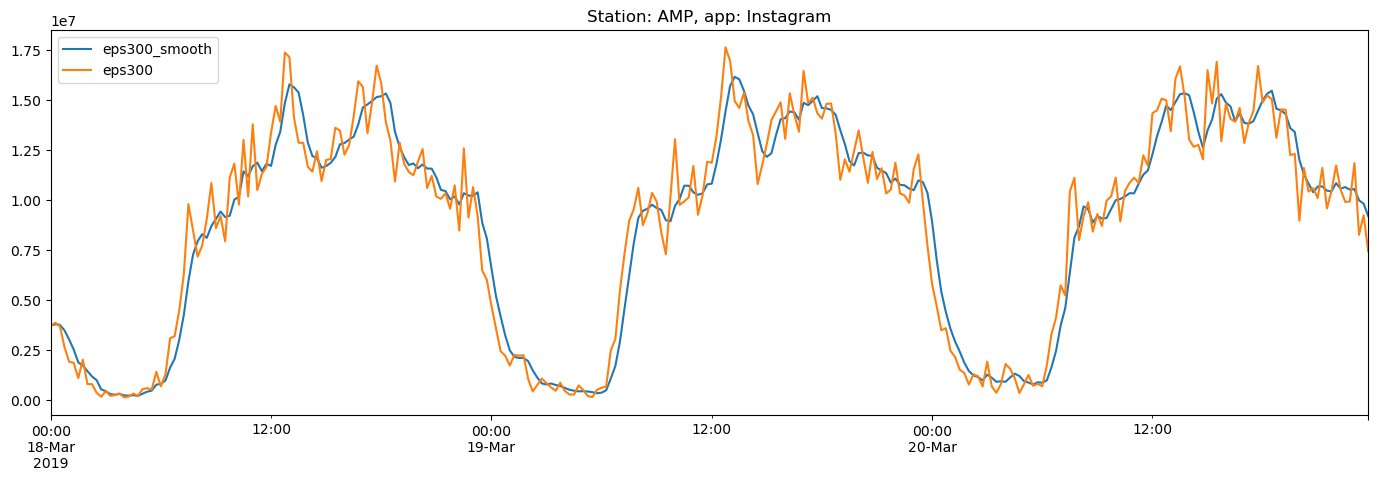

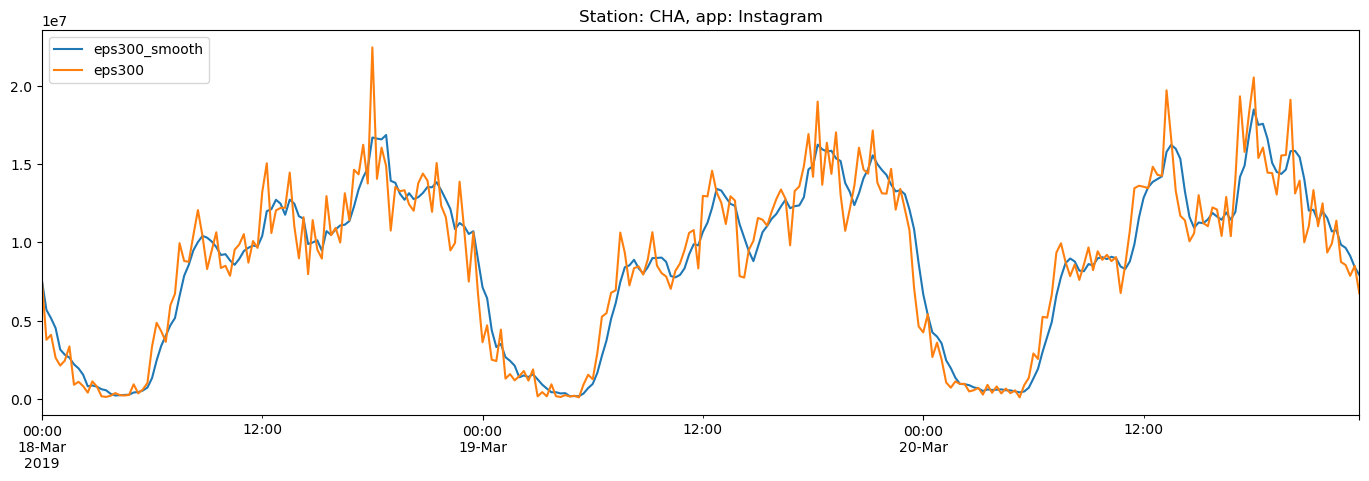

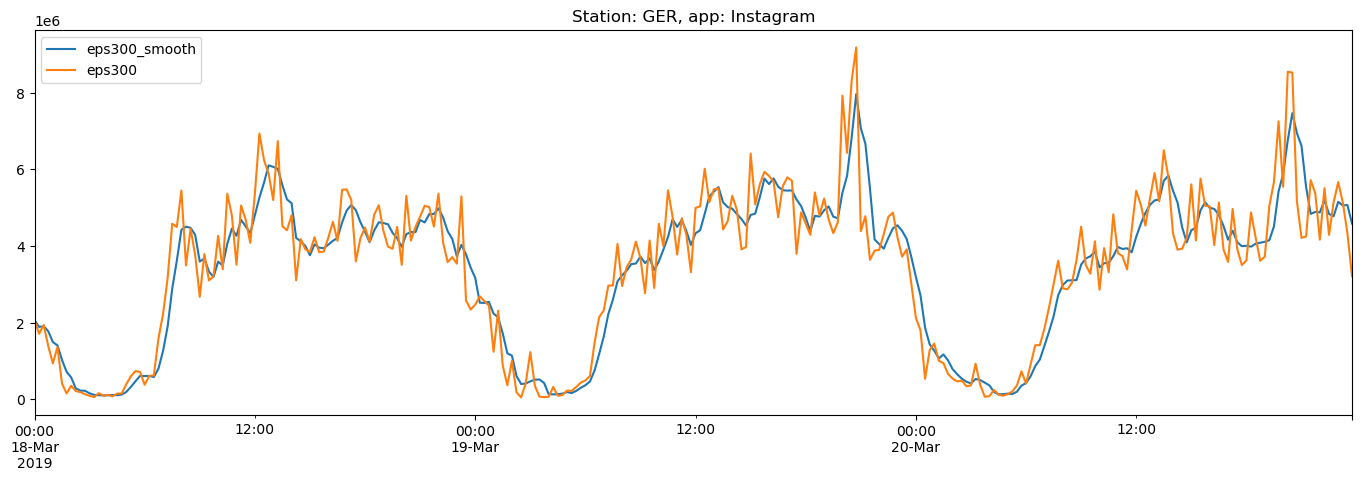

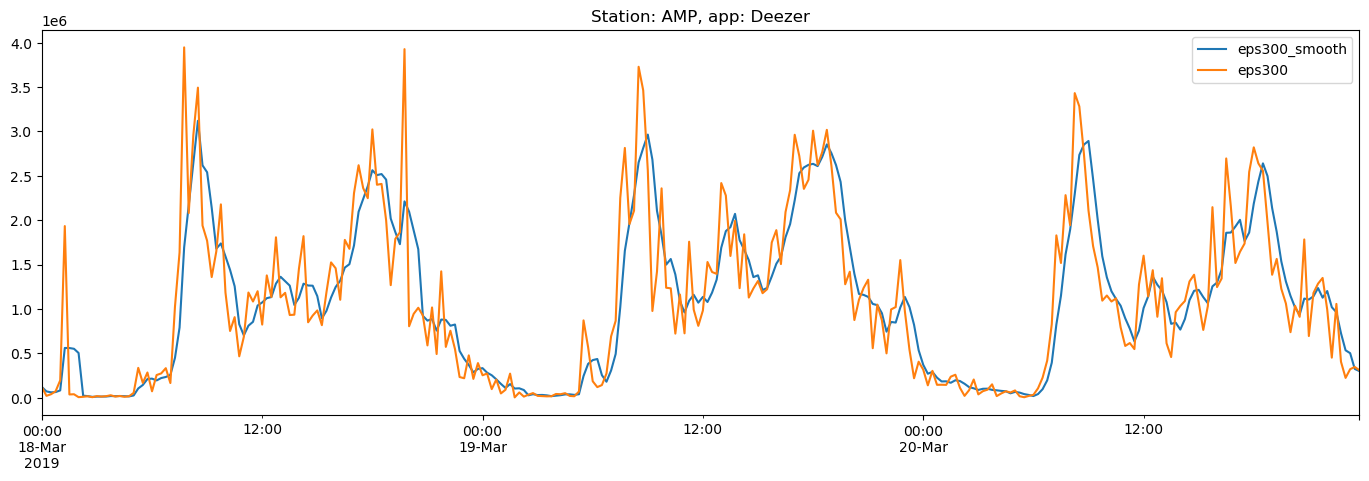

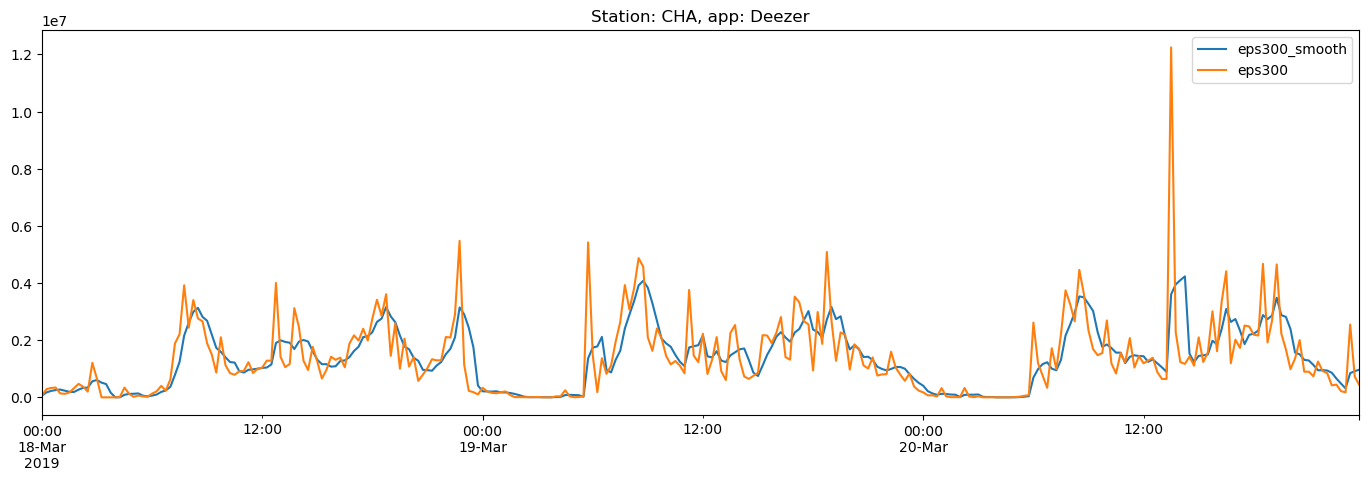

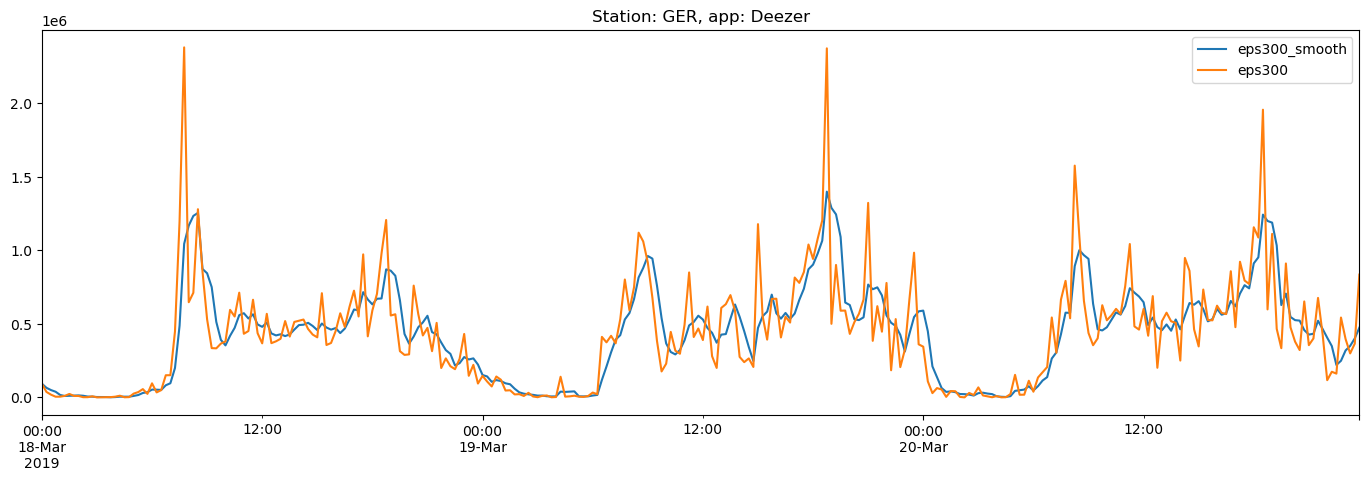

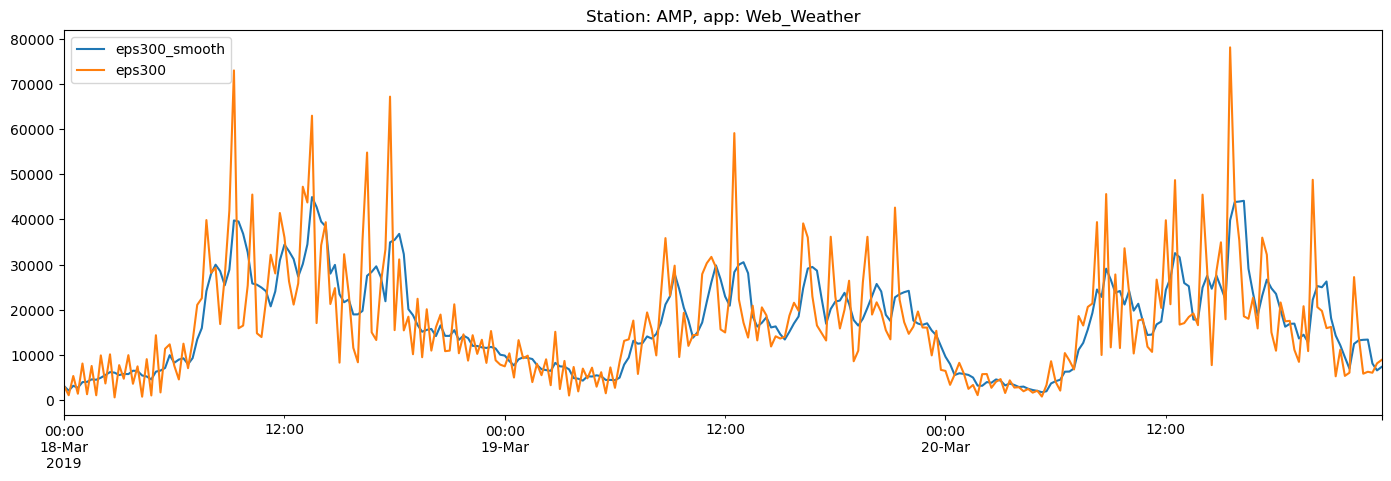

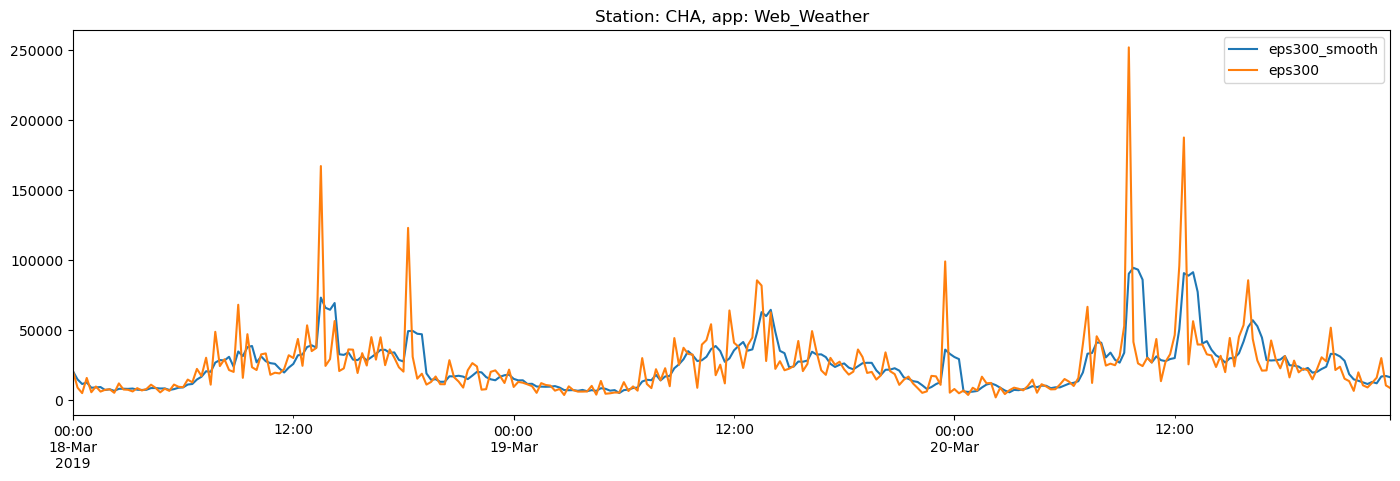

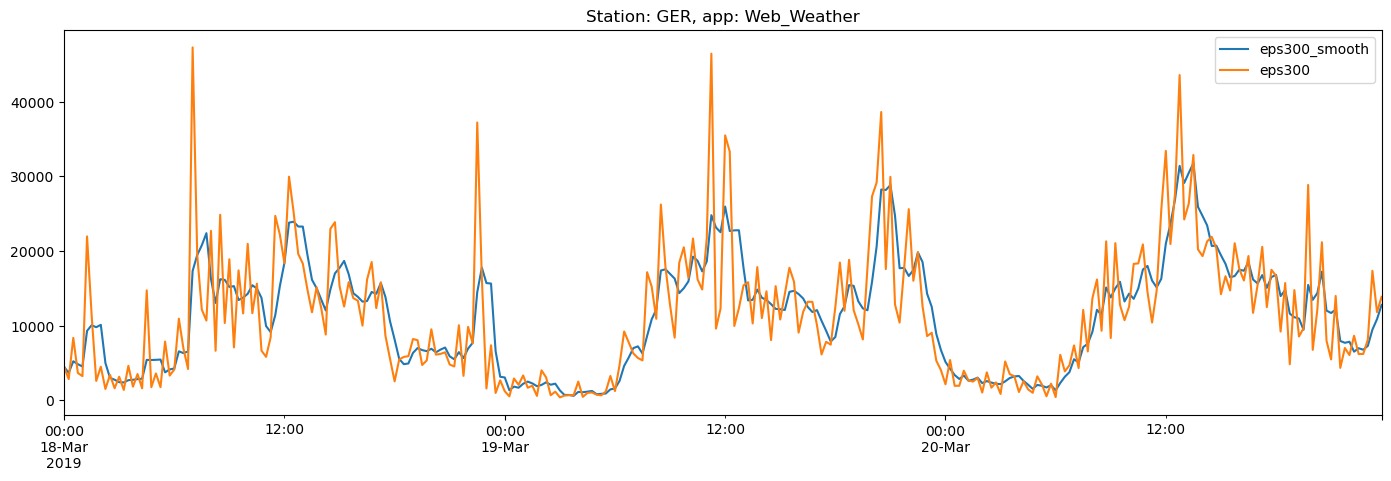

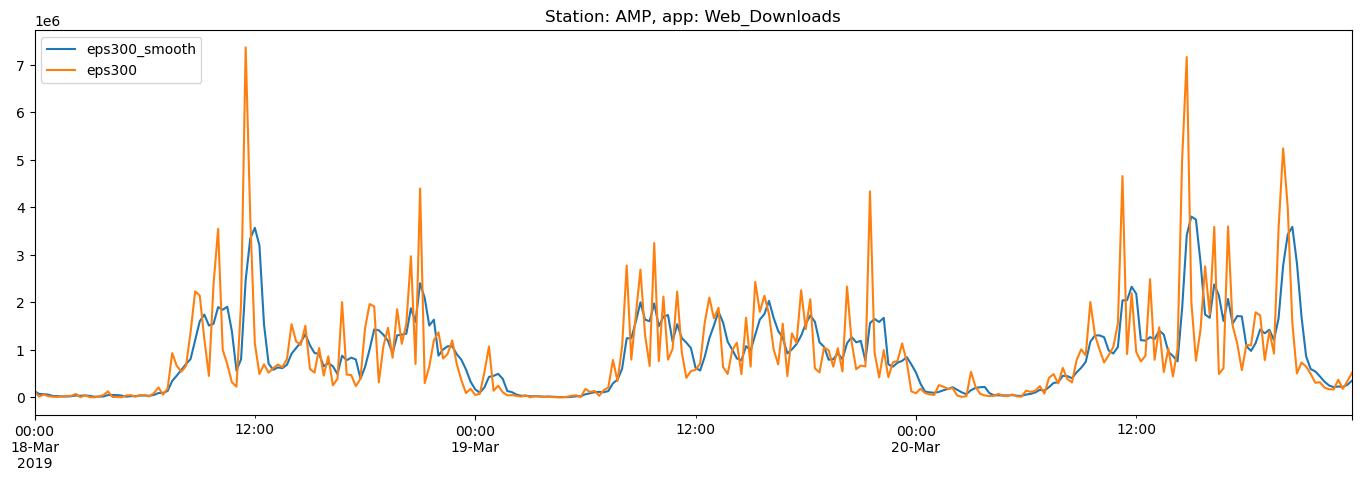

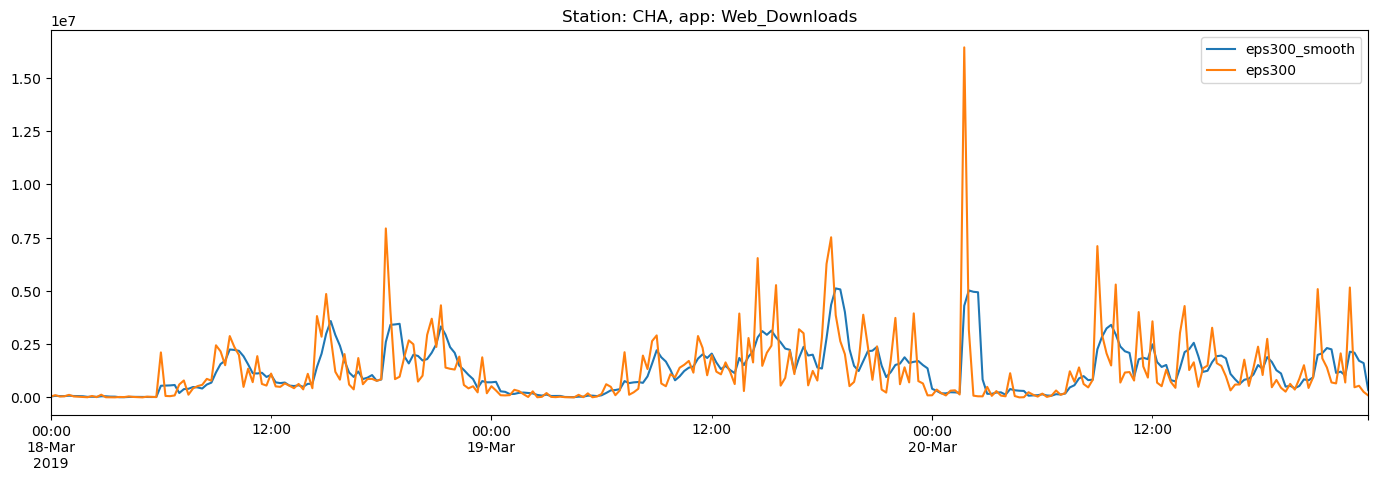

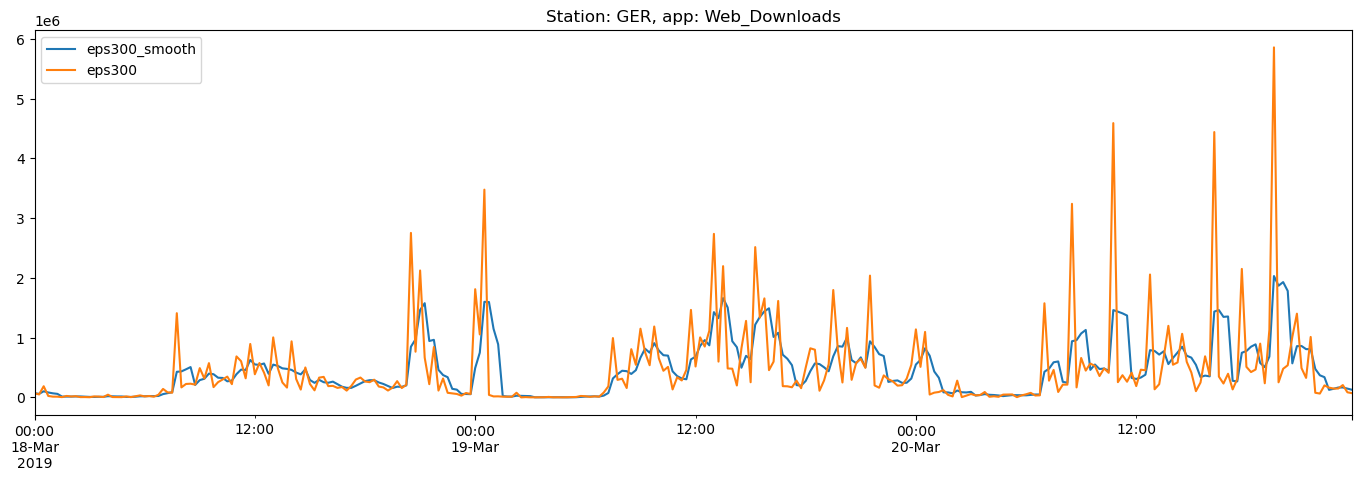

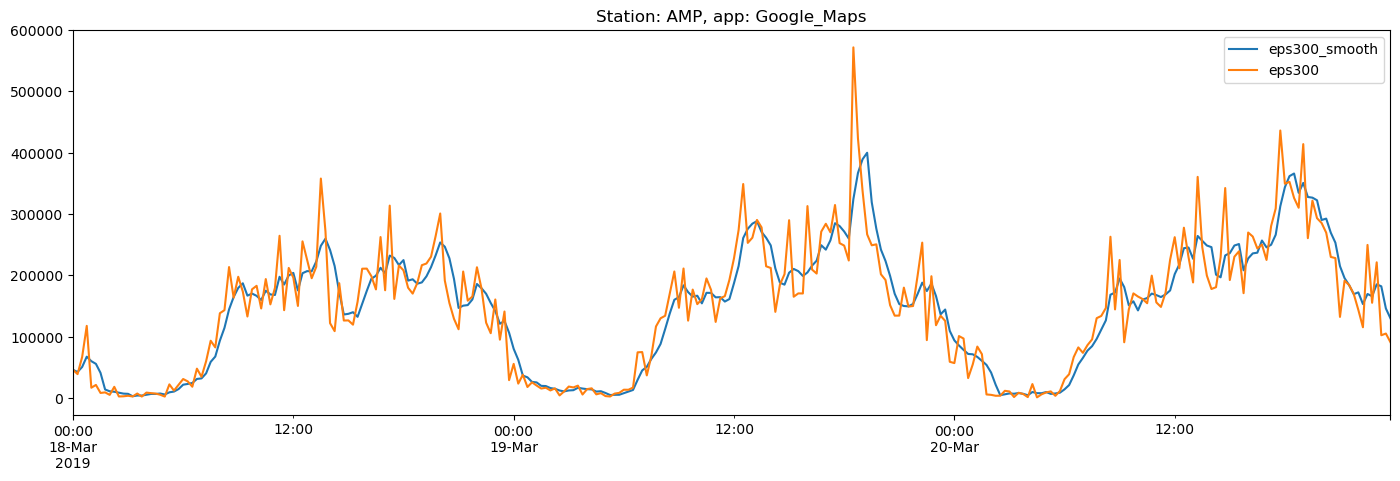

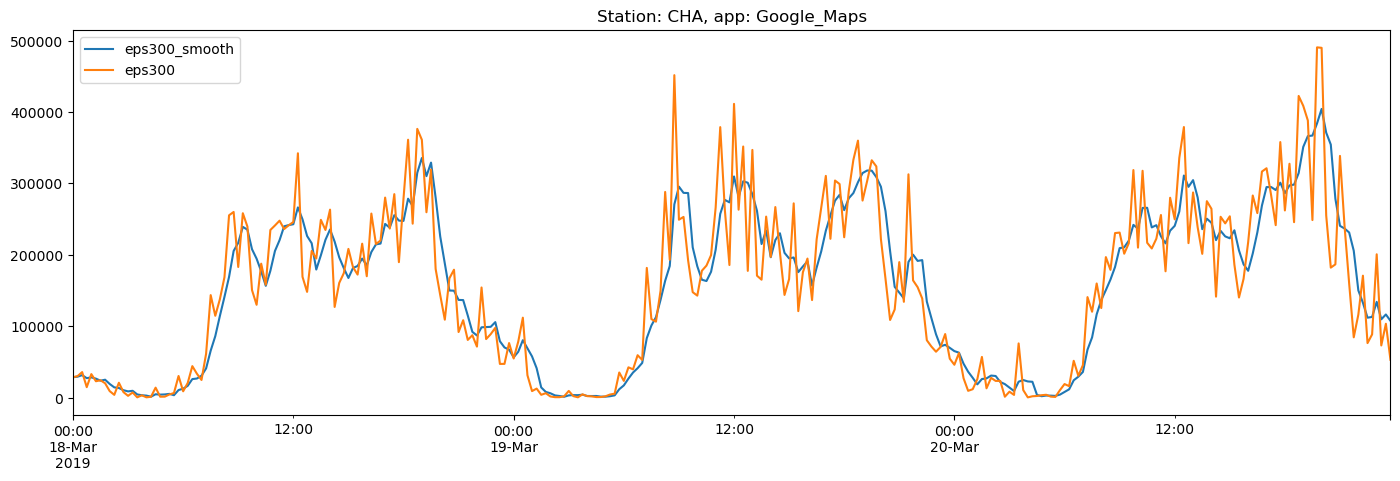

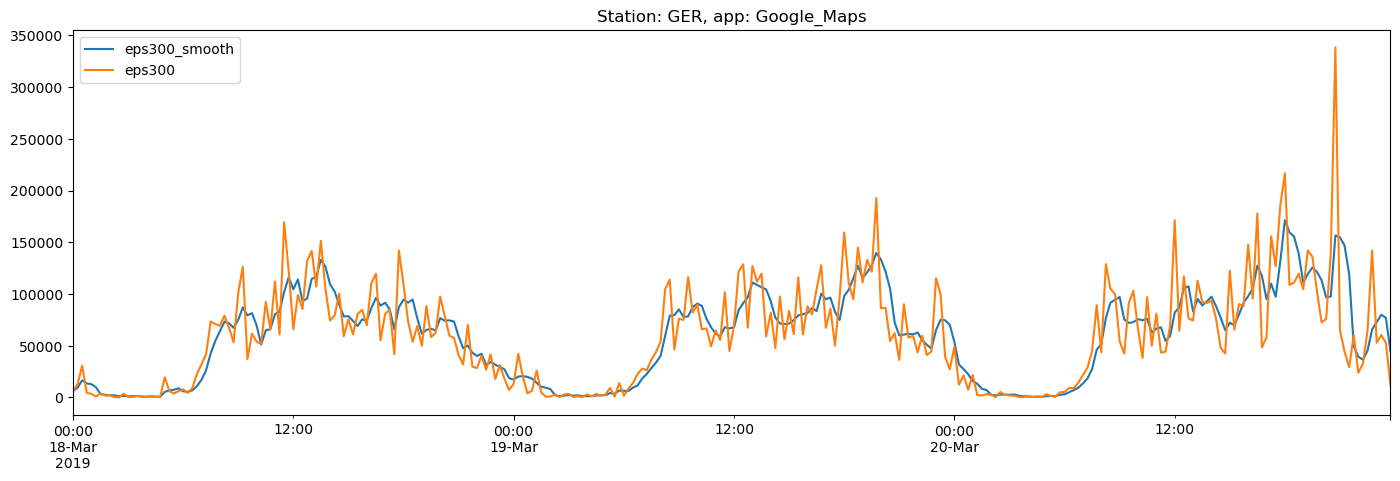

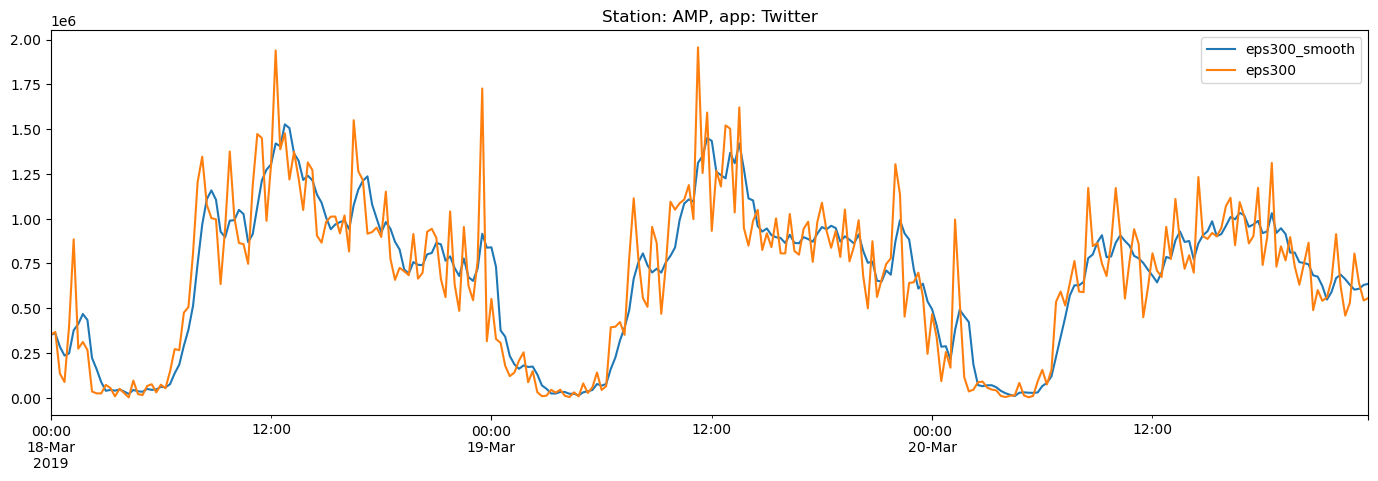

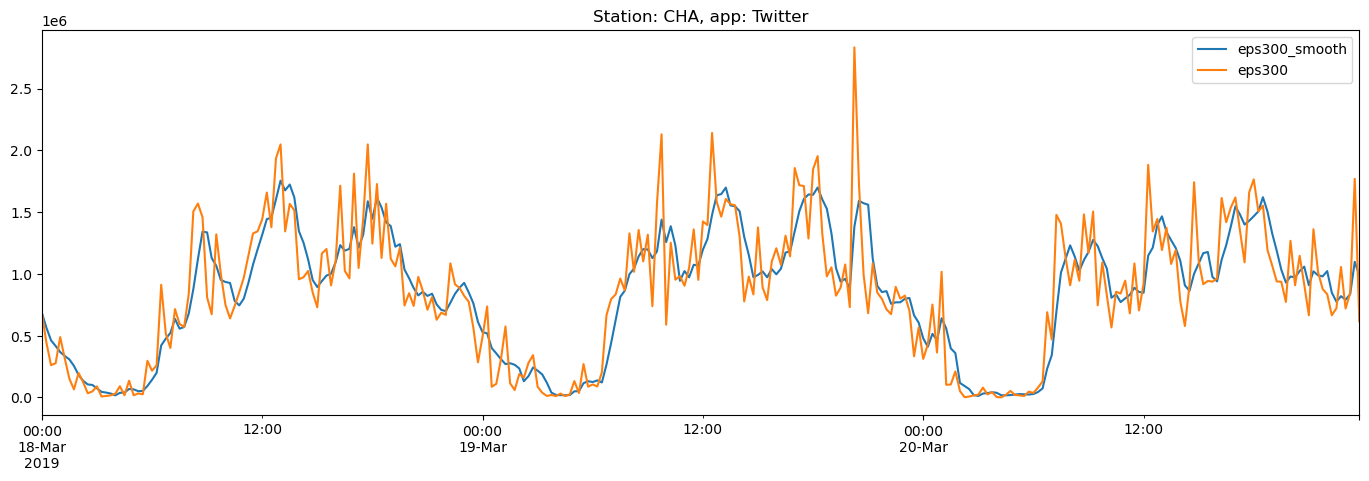

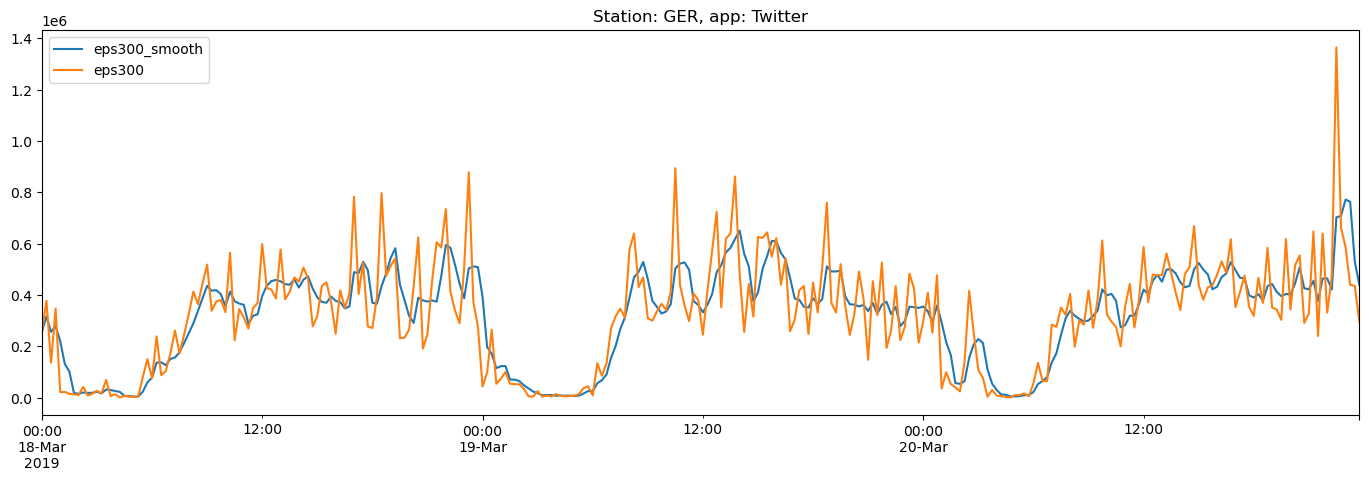

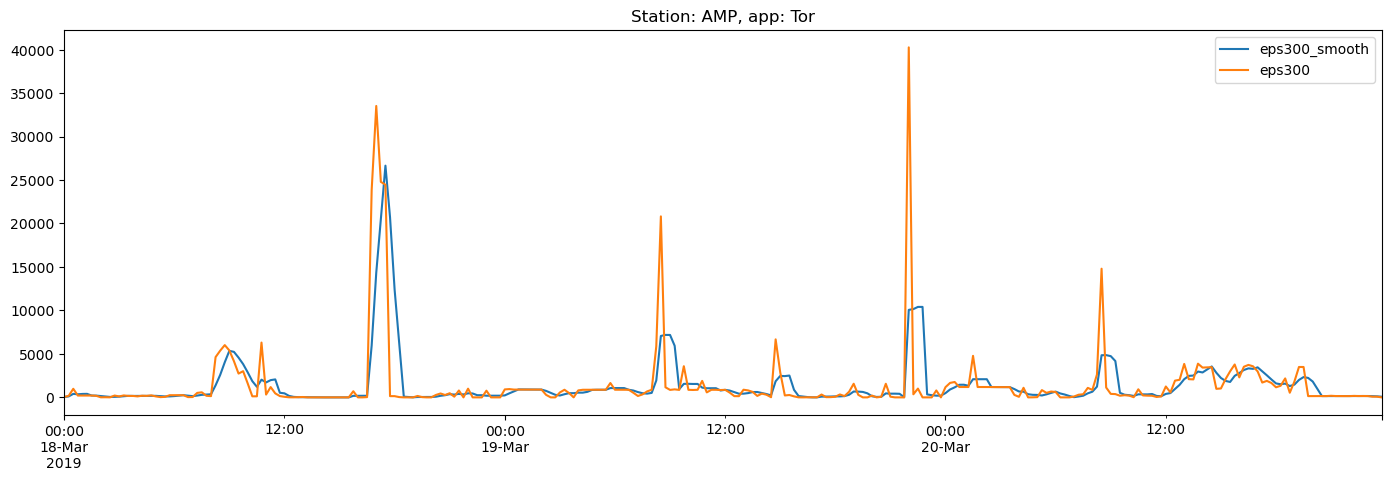

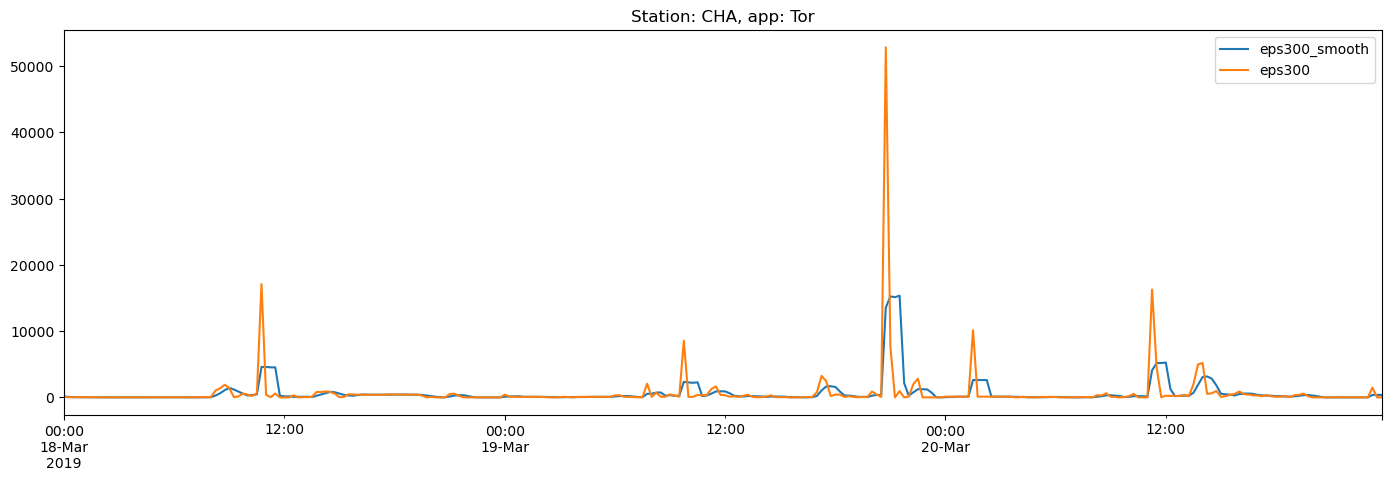

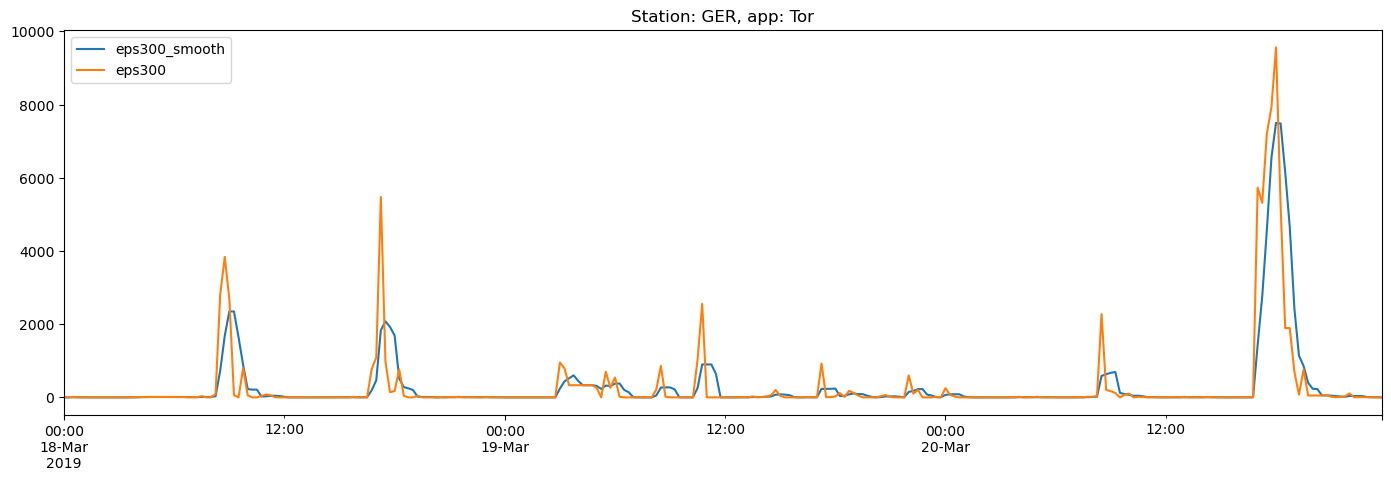

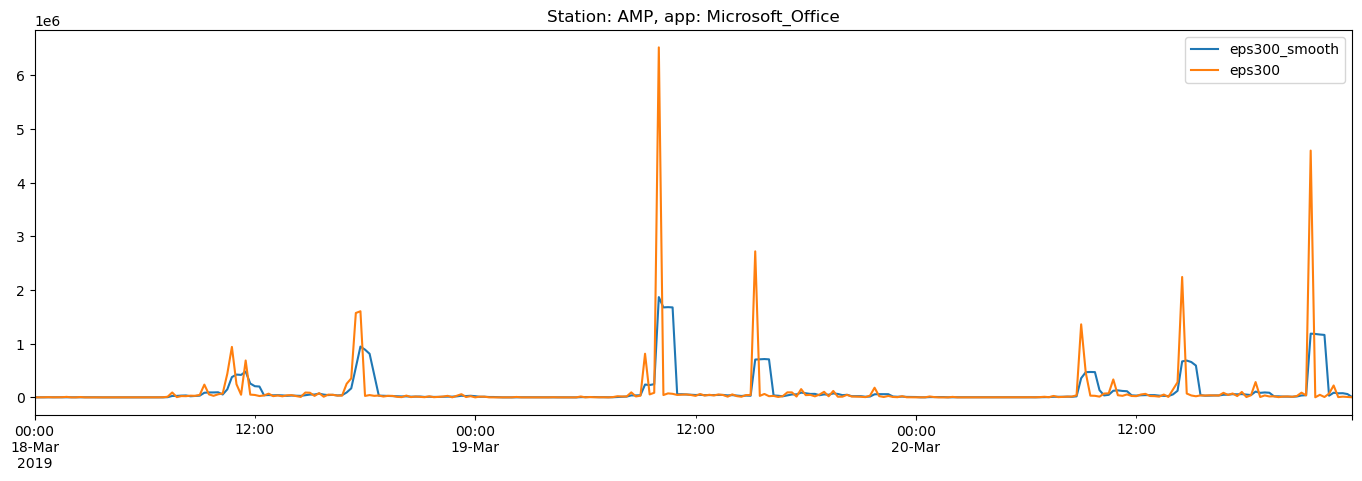

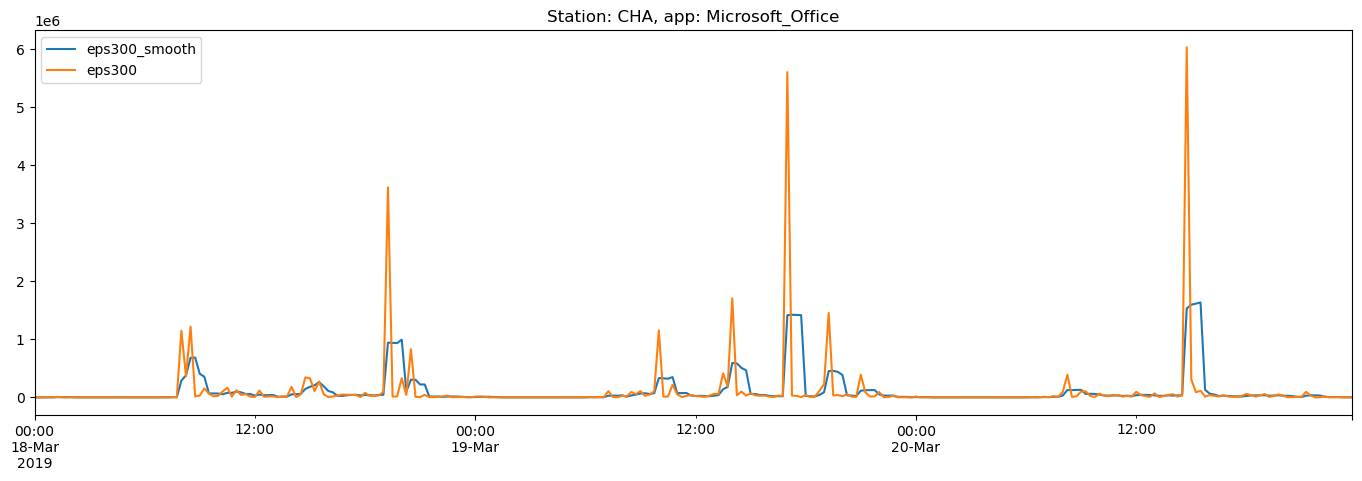

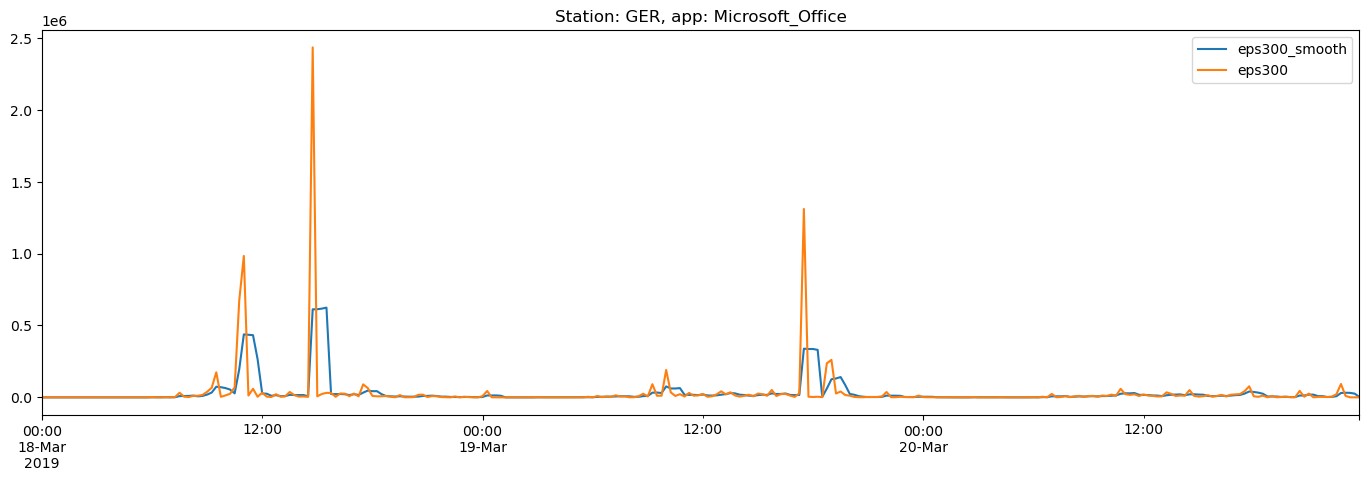

In [40]:
#data_dict_eps300 = pickle.load(open('NetMob_samples_epsilon300.pkl','rb'))
#data_dict_eps100 = pickle.load(open('NetMob_samples_epsilon100.pkl','rb'))

stations = ['AMP', 'BLA', 'BRO', 'COR', 'CRO', 'CUS', 'FLA', 'GAR', 'GIL', 'GRA', 'HEN', 'JAU', 'LAE', 'MAC', 'MER', 'PAR', 'PRY', 'SAN', 'SOI', 'VEN',
            'BEL', 'BON', 'CHA', 'CPA', 'CUI', 'DEB', 'FOC', 'GER', 'GOR', 'GUI', 'HOT', 'JEA', 'LUM', 'MAS', 'OGA', 'PER', 'REP', 'SAX', 'VAI', 'VMY']
Apps = ['Instagram', 'Deezer','Web_Weather','Web_Downloads','Google_Maps','Twitter','Tor','Microsoft_Office']
#7*96*2
def temporal_moving_average(df, window_size):
    return df.rolling(window=window_size, min_periods=1, closed='both').mean()

start,end = 2*96,5*96
for app_j in Apps:
    for station_i in ['AMP','CHA','GER']:
        data_dict_eps300_bis = data_dict_eps300[station_i][app_j][start:end].copy()
        data_dict_eps100_bis = data_dict_eps100[station_i][app_j][start:end].copy()
        #data_dict_eps300_bis = (data_dict_eps300_bis-data_dict_eps300_bis.min())/(data_dict_eps300_bis.max()-data_dict_eps300_bis.min())
        #data_dict_eps100_bis = (data_dict_eps100_bis-data_dict_eps100_bis.min())/(data_dict_eps100_bis.max()-data_dict_eps100_bis.min())
        #df_i =pd.DataFrame(np.array([data_dict_eps300_bis,data_dict_eps100_bis]).transpose(),index = coverage_local[start:end],columns = ['eps300','eps100'])
        df_to_smooth = pd.DataFrame(np.array(data_dict_eps300_bis).transpose(),index = coverage_local[start:end],columns = ['eps300_smooth'])
        data_dict_eps300_bis_smooth = temporal_moving_average(df_to_smooth, window_size=3)
        df_i =pd.DataFrame(np.array([data_dict_eps300_bis_smooth.values.reshape(-1),data_dict_eps300_bis]).transpose(),index = coverage_local[start:end],columns = ['eps300_smooth','eps300'])
        #df_i = temporal_moving_average(df_i, window_size=2)
        df_i.plot(title = f"Station: {station_i}, app: {app_j}",figsize=(17,5))

## Get Netmob from POIs:
Légèrement différent. Nécessite d'avoir accès en parallèle à un geopandas pour savoir de quel OSMID on parle:

In [ ]:
# POIs:
POI_types = ['iris','nightclub','park','parkings','public_transport','shop','stadium','station','theatre','transit','university']
Apps = ['Facebook','Google','Instagram','LinkedIn','Messenger','Snapchat','Twitter','WhatsApp']
POI_type = POI_types[0]
app_j = Apps[0]
transfer_mode = 'DL'

In [ ]:
# Aggregated data: 
path_agg_POI = f'POIs/netmob_POI_Lyon/Inputs/agg_TS/{POI_type}/{station_i}/{transfer_mode}'
data_path_agg,metadata_path_agg = f'{path_agg_POI}/data.npy', f'{path_agg_POI}/metadata.pkl' #Contains TS from all osmid of the same POI type

In [ ]:
# Time Series of POIs data: 
path_POI = f'POIs/netmob_POI_Lyon/Inputs/{station_i}'
data_path,metadata_path = f'{path_POI}/data.npy', f'{path_POI}/metadata.pkl' #contains 68 apps, all POIs

In [ ]:
## Time series data
f'POIs/netmob_POI_Lyon/{POI_type}/{app_j}/df_{osmid}_{transfer_mode}.csv'

## rien a voir

In [13]:
import pandas as pd
import os
import sys
import glob
path = '/home/rrochas/prediction-validation/save/K_fold_validation/training_with_HP_tuning/ASTGCN_2025_04_21_20_06_76371/'

list_csv = glob.glob(f"{path}*")
metrics_csv = [csv_path for csv_path in list_csv if 'METRICS_s' in csv_path]
losses_csv = [csv_path for csv_path in list_csv if 'Losses' in csv_path]

df_tot = pd.DataFrame()
for csv_path in metrics_csv:
    df_results = pd.read_csv(csv_path,index_col=0)
    trial_name = csv_path.split('76371')[-1][:-4]
    df_results['trial_name'] = trial_name
    df_tot = pd.concat([df_tot,df_results])
df_tot.loc['test'].set_index('trial_name')

,mse,mae,mape,mase,VAR_mse,VAR_mae,VAR_mape,VAR_mase,mse_complete_ds,mae_complete_ds,mape_complete_ds,mase_complete_ds
trial_name,,,,,,,,,,,,
subway_in_subway_out,1395.589233,22.009519,33.414791,0.714845,7109.694205,0.474380,11.462296,0.001928,1385.177246,21.834917,30.174503,0.681952
subway_in_subway_in,1437.444604,22.288612,32.871791,0.724384,5295.620212,0.395379,13.998599,0.002534,1435.644897,21.759230,30.017078,0.679505
station_epsilon100_Google_Maps,1531.804443,23.109518,34.713005,0.750498,10953.057676,0.982966,17.098634,0.002452,1477.172485,22.344402,29.677530,0.697943
station_epsilon100_Web_Weather,1417.820923,22.306835,34.520028,0.724395,229.888862,0.065928,9.670976,0.001280,1436.811401,22.356100,35.271950,0.698285
station_epsilon100_Web_Downloads,1455.519849,22.664582,35.607247,0.736529,3303.643634,0.471216,40.999183,0.002557,1460.185547,22.642090,34.627018,0.707224
station_epsilon100_Web_Deezer,1447.048975,22.571531,33.928539,0.733272,553.636681,0.117010,22.042596,0.001869,1465.362671,22.300707,31.896473,0.696368


In [18]:
import sys
import os
import pickle 
current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

L_df_losses = []
for csv_path in losses_csv:
    df_losses = pd.read_csv(csv_path,index_col=0)
    df_losses = df_losses[['fcomplete_dataset_train_loss','fcomplete_dataset_valid_loss']]
    df_losses=df_losses.rename(columns={'fcomplete_dataset_train_loss':f'Train {trial_name}',
    'fcomplete_dataset_valid_loss':f'Valid {trial_name}'})
    L_df_losses.append(df_losses)


from plotting.TS_analysis import plot_TS

plot_TS(L_df_losses,width=1200,height=400,bool_show=True,title=f"Losses",x_datetime = False)

Loading BokehJS ...

figure(id='p1001', ...)